In [1]:
from ultralytics import YOLO
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# model_path = "./runs/segment/train2/weights/best.pt"
# model_path = "E:\SLIIT\__4th_Year\Research Project - IT4010\dev\ENT-disease-detection-dl-models\runs\detect\train2\weights\best.pt"
# model_path = "../../../runs/detect/train2/weights/best.pt"
model_path = "./runs/detect/train6/weights/best.pt"
image_path = "E:\SLIIT\__4th_Year\Research Project - IT4010\Dataset - Waters View Sinus X Ray\sinusities_dataset\mild\mild_18.JPEG"
# image_path = "E:\SLIIT\__4th_Year\Research Project - IT4010\Dataset - Waters View Sinus X Ray\Yolo\detect\images\\train\d (13).jpg"

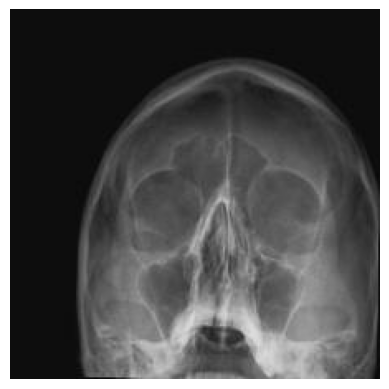

In [6]:

image = Image.open(image_path).convert("RGB")

# Show the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

### Predict the maxillary area  


image 1/1 E:\SLIIT\__4th_Year\Research Project - IT4010\Dataset - Waters View Sinus X Ray\sinusities_dataset\mild\mild_18.JPEG: 640x640 1 Healthy, 2 Moderates, 469.2ms
Speed: 3.4ms preprocess, 469.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Detected classes and confidence scores:
Class: Moderate, Confidence: 0.39, BBox: [75, 145, 115, 186]
Class: Healthy, Confidence: 0.34, BBox: [74, 146, 116, 190]
Class: Moderate, Confidence: 0.26, BBox: [143, 150, 183, 194]


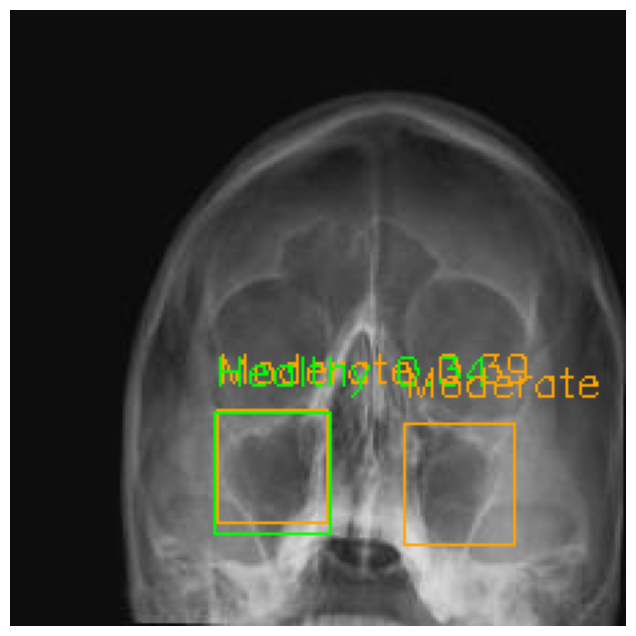

In [7]:
 # Load the trained model
model = YOLO(model_path)  # Path to your trained model weights

# Perform prediction on the single image
# results = model.predict(source=image_path, imgsz=640)  # Adjust confidence threshold if needed
# Run inference on test images
results = model.predict(
    # source="E:/annotate_maxillary/yolo/dataset/detect/images/test",  # Test images folder
    conf=0.25,   # Confidence threshold (adjust based on validation)
    save=True,   # Save annotated images
    save_txt=True,  # Save labels in YOLO format
    project="runs/detect",  # Output directory
    name="test_results"
)
# Define custom colors for each class
class_colors = {
    "Healthy": (0, 255, 0),   # Green
    "Moderate": (0, 165, 255),  # Orange
    "Severe": (0, 0, 255)      # Red
}

image = cv2.imread(image_path)

# Display results
# Process and draw bounding boxes with custom colors
for result in results:
    print("Detected classes and confidence scores:")
    for box in result.boxes:  # Iterate over detected bounding boxes
        class_id = int(box.cls)  # Class ID
        class_name = model.names[class_id]  # Class name
        confidence = float(box.conf)  # Confidence score
        bbox = [int(coord) for coord in box.xyxy[0]]  # Bounding box coordinates [x1, y1, x2, y2]

        # Get the color for the current class
        color = class_colors[class_name]

        # Draw the bounding box
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness=1)

        # Add a label with the class name and confidence score
        label = f"{class_name} {confidence:.2f}"
        cv2.putText(image, label, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness=1)

        print(f"Class: {class_name}, Confidence: {confidence:.2f}, BBox: {bbox}")

# Display the annotated image
# Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the annotated image inline using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

# Optionally, save the annotated image
# output_path = "path/to/save/output_image.jpg"
# cv2.imwrite(output_path, image)